In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn import model_selection
import numpy as np
import re
import pickle
from sklearn.ensemble import RandomForestRegressor
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver import Chrome
from time import sleep
from tqdm.notebook import tqdm


options = Options() 
options.add_argument('--headless')
options.add_argument('--disable-gpu')             
options.add_argument('--disable-extensions')       
options.add_argument('--proxy-server="direct://"') 
options.add_argument('--proxy-bypass-list=*')      
options.add_argument('--start-maximized')      
driver = Chrome(executable_path="", options=options)

In [84]:
id = '202306020203'

In [85]:
url = 'https://race.netkeiba.com/race/shutuba.html?race_id=' + id

In [86]:
df = pd.read_html(url)[0]
newCol = []
for i in df.columns:
    newCol.append(i[0])
df.columns = newCol

In [87]:

target_url = url
driver.get(target_url)
sleep(1)

table = driver.find_elements(By.XPATH,'//*[@id="page"]/div[3]/div[2]/table/tbody/tr')
horse_jockey_id = []
for i in range(1,len(table)+1):
    result_id = []

    # horse_id
    sleep(1)
    horse_id = driver.find_elements(By.XPATH,'//*[@id="page"]/div[3]/div[2]/table/tbody/tr[' + str(i) +']/td[4]')
    horse_id = re.sub( r'\D+', '', horse_id[0].get_attribute('outerHTML').split('/horse')[1].split('title')[0])
    result_id.append(horse_id)

    # jockey_id
    sleep(1)
    jockey_id = driver.find_elements(By.XPATH,'//*[@id="page"]/div[3]/div[2]/table/tbody/tr[' + str(i) +']/td[7]')
    jockey_id = re.sub( r'\D+', '', jockey_id[0].get_attribute('outerHTML').split('/recent')[1])
    result_id.append(jockey_id)

    horse_jockey_id.append(result_id)  

df = pd.concat([df, pd.DataFrame(horse_jockey_id,columns=['horse_id', 'jockey_id'])], axis=1)

In [ ]:
horse_id_list = df['horse_id']
target_url = "https://regist.netkeiba.com/account/?pid=login"
driver.get(target_url)
sleep(1)

USERNAME = ""
PASSWORD = 

username_input = driver.find_elements(By.XPATH,'//*[@id="contents"]/div/form/div/ul/li[1]/input')
username_input[0].send_keys(USERNAME)
sleep(1)

username_input = driver.find_elements(By.XPATH,'//*[@id="contents"]/div/form/div/ul/li[2]/input')
username_input[0].send_keys(PASSWORD)
sleep(1)

username_input = driver.find_elements(By.XPATH,'//*[@id="contents"]/div/form/div/div[1]/input')
username_input[0].click()
sleep(1)

deokure_count_detail = {}
for horse_id in tqdm(horse_id_list):
    try:
        sleep(1)
        rece = driver.get('https://db.netkeiba.com/horse/' + horse_id)
        sleep(1)
        table = driver.find_elements(By.XPATH,'//*[@id="contents"]/div[4]/div/table')
        html = table[0].get_attribute('outerHTML')

        deokureCount = 0
        for i in range(len(pd.read_html(html)[0])):
            if '出遅れ' == pd.read_html(html)[0].loc[[i]]['備考'][i]:
                deokureCount = deokureCount + 1

        horse_detail_list = []
        horse_detail = []
        horse_detail.append(deokureCount)
        horse_detail.append(len(pd.read_html(html)[0]))
        horse_detail_list.append(horse_detail)
        deokure_count_detail[horse_id] = pd.DataFrame(horse_detail_list,columns=['deokureNum','raceNum'])
    except Exception:
        continue

for key in deokure_count_detail:
    deokure_count_detail[key].index = [key] * len(deokure_count_detail[key])
results = pd.concat([deokure_count_detail[key] for key in deokure_count_detail], sort=False)
results = results.reset_index()
df = pd.concat([df, results], axis=1)

In [89]:
import urllib.request
from bs4 import BeautifulSoup

res = urllib.request.urlopen(url)
soup = BeautifulSoup(res, 'html.parser')
raceDate = soup.select('.RaceData01')
raceDate = raceDate[0].text.replace(' ', '')

In [90]:
initial_Value = df.copy()

In [91]:
df['馬体重(増減)'].str[4:].str.replace(')','', regex=True).str[1:]

0      2
1     12
2       
3      6
4      6
5      2
6      6
7      6
8       
9      2
10      
11     6
12     2
13     6
14     8
15     2
Name: 馬体重(増減), dtype: object

In [92]:
df['性別'] = df['性齢'].str[0]
df['年齢'] = df['性齢'].str[1:3]
df['年齢'] = df['年齢'].astype(int)
df.drop('性齢', axis=1,inplace=True)
result = []
for i  in df['馬体重(増減)'].str[4:].str.replace(')','', regex=True).str[0]:
    if i=='+':
        result.append(1)
    elif i=='-':
        result.append(2)
    else:
        result.append(0)

df['加減'] = result
df['体重増減'] = df['馬体重(増減)'].str[4:].str.replace(')','', regex=True).str[1:]
df.loc[(df.体重増減 == ''), '体重増減'] = '0'
df.loc[(df.体重増減 == '計不'), '体重増減'] = '0'
df['体重増減'] = df['体重増減'].astype(int)
df['馬体重'] = df['馬体重(増減)'].str[0:3]
# df.loc[(df.馬体重 !='計不'), ['馬体重']].astype(float).mean().round().astype(int)
df.loc[(df.馬体重=='計不'), '馬体重'] = '471'
df.loc[(df.馬体重=='--'), '馬体重'] = '471'
df['馬体重'] = df['馬体重'].astype(int)

In [93]:
df.drop(['印', '馬名','枠','人気', '騎手', 'お気に入り馬', 'Unnamed: 9_level_0', '厩舎', '馬体重(増減)','index'], axis=1, inplace=True)

In [94]:
df['horse_id'] = df['horse_id'].astype(int)
df['jockey_id'] = df['jockey_id'].astype(int)

In [95]:
dummy = df[['性別']]
dummy = pd.get_dummies(dummy)
newDf = pd.concat([df, dummy], axis=1)
newDf.drop(['性別'],axis=1,inplace=True)

In [96]:
newDf = newDf[['jockey_id', 'deokureNum', 'raceNum', '馬体重', '体重増減', '馬番', '斤量', '加減']]

In [97]:
import pandas as pd
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn import model_selection
import numpy as np
import re
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

df1 = pd.read_pickle('')
df2 = pd.read_pickle('')
df3 = pd.read_pickle('')
df4 = pd.read_pickle('')
df = pd.concat([df1,df2,df3],axis=1)
df = df.merge(df4, on='horse_id')

df.drop(['タイム', '着差', '着順', '馬名', 'ﾀｲﾑ指数', '通過', '上り', '調教ﾀｲﾑ', '厩舎ｺﾒﾝﾄ', '賞金(万円)','調教師','枠番','人気','馬主', '騎手', '単勝'], axis=1, inplace=True)

df = df.drop_duplicates(subset=df.columns)

result = []
for i in  df['time']:
    try:
         appendResult = i.split(':')[0]
         appendResult = re.sub( r'\D+', '', appendResult)
         if(appendResult == ''):
            result.append(0)
            continue
         result.append(appendResult)
    except IndexError:
        result.append(0)
        continue
        

df['timeHour'] = result
df.drop('time', axis=1, inplace=True)

result = []
for i in df['situation']:
    if(i == "良"):
        result.append(0)
    elif(i=="稍重"):
        result.append(1)
    elif(i=="重"):
        result.append(2)
    else:
        result.append(3)
df['situation'] = result

result = []
for i in df['whether']:
    if(i == "晴"):
        result.append(0)
    elif(i=="曇"):
        result.append(1)
    elif(i=="雨"):
        result.append(2)
    else:
        result.append(3)
df['whether'] = result

result = []
for i in df['distance']:
    result.append(re.sub( r'\D+', '', i))
df['distance'] = result
df['distance'] = df['distance'].astype(int)

df.loc[(df.rightORleft=='芝'), 'rightORleft'] = np.nan

result = []
for i in df['track']:
    if(i == "ダ"):
        result.append(0)
    elif(i=="芝"):
        result.append(1)
    else:
        result.append(2)
df['track'] = result

df['性別'] = df['性齢'].str[0]
df['年齢'] = df['性齢'].str[1:3]
df['年齢'] = df['年齢'].astype(int)
df.drop('性齢', axis=1,inplace=True)

result = []
for i  in df['馬体重'].str[4:].str.replace(')','', regex=True).str[0]:
    if i=='+':
        result.append(1)
    elif i=='-':
        result.append(2)
    else:
        result.append(0)

df['加減'] = result
df['体重増減'] = df['馬体重'].str[4:].str.replace(')','', regex=True).str[1:]
df.loc[(df.体重増減 == ''), '体重増減'] = '0'
df['体重増減'] = df['体重増減'].astype(int)
df['馬体重'] = df['馬体重'].str[0:3]
# df.loc[(df.馬体重 !='計不'), ['馬体重']].astype(float).mean().round().astype(int)
df.loc[(df.馬体重=='計不'), '馬体重'] = '471'
df['馬体重'] = df['馬体重'].astype(int)


result = []

for i in df['備考']:
    if i=='出遅れ':
        result.append(1)
    else:
        result.append(0)

df['出遅れ'] = result
df.drop('備考', axis=1, inplace=True)

df['timeHour'] = df['timeHour'].astype(int)
dummy = df[['timeHour','性別','rightORleft']]
dummy = pd.get_dummies(dummy)
dummy = pd.concat([dummy, df[['斤量','馬体重', '馬番','馬体重','体重増減','加減','年齢']]], axis=1)

known_tansyo = dummy[dummy.timeHour != 0].values  
unknown_tansyo = dummy[dummy.timeHour == 0].values


X = known_tansyo[:, 1:]  
y = known_tansyo[:, 0]

rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)

predictedTansyo = rfr.predict(unknown_tansyo[:, 1::])
df.loc[(df.timeHour == 0), 'timeHour'] = predictedTansyo.round().astype(int)

df['rightORleft'].fillna("右", inplace=True)
df['horse_id'] = df['horse_id'].astype(int)
df['jockey_id'] = df['jockey_id'].astype(int)
df['deokureNum'] = df['deokureNum'].astype(int)
df['raceNum'] = df['raceNum'].astype(int)

dummy = df[['rightORleft','性別']]
dummy = pd.get_dummies(dummy)
oldDf = pd.concat([df, dummy], axis=1)
oldDf.drop(['rightORleft','性別'],axis=1,inplace=True)

oldDf = oldDf[['jockey_id', 'deokureNum', 'raceNum', '馬体重', '体重増減', '馬番', '斤量', '加減','出遅れ']]
X = oldDf.drop('出遅れ',axis=1)
y = oldDf['出遅れ']
params =  {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0, 'num_leaves': 127, 'n_estimators': 1000, 'min_child_samples': 30, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
# params = {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0, 'num_leaves': 31, 'n_estimators': 100, 'min_child_samples': 20, 'max_depth': 15, 'learning_rate': 0.05, 'colsample_bytree': 0.9}

# LightGBMのモデルを定義する
lgbm_clf = lgb.LGBMClassifier(**params)


lgbm_clf.fit(X, y)

LGBMClassifier(colsample_bytree=0.9, learning_rate=0.01, max_depth=5,
               min_child_samples=30, n_estimators=1000, num_leaves=127,
               reg_alpha=0, reg_lambda=0.1, subsample=0.8)

In [98]:
from sklearn.metrics import accuracy_score 
y_pred = lgbm_clf.predict_proba(newDf)

In [99]:
result = pd.DataFrame(y_pred, columns=['出遅れない', '出遅れ率'])['出遅れ率']

In [100]:
test = pd.merge(result, initial_Value[['馬番', '馬名']],left_index=True, right_index=True).sort_values(by="出遅れ率", ascending=False)

In [101]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'MS Gothic'
def TablePlot(df,outputPath,w,h):
    fig, ax = plt.subplots(figsize=(w,h))
    ax.axis('off')
    ax.table(cellText=df.values,
             colLabels=df.columns,
             loc='center',
             bbox=[0,0,1,1])
    plt.savefig(outputPath)

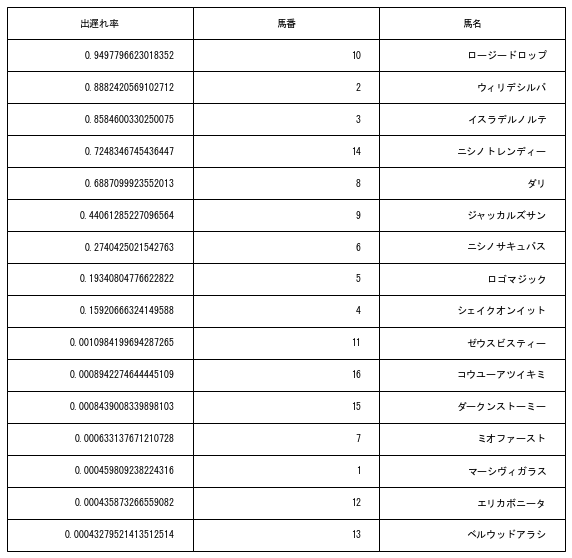

In [102]:
TablePlot(test, '', 10, 10)

In [ ]:
result = pd.merge(result, initial_Value[['馬番', '馬名']],left_index=True, right_index=True).sort_values(by="出遅れる", ascending=False)

In [ ]:

print(hex(ord("🪄"))) 

0x1fa84


In [ ]:
racePlace = str(url.split('=')[1])[4:6]
raceNumber = str(url.split('=')[1])[10:12]

racePlaceName = ''
if(racePlace == '05'):
    print('東京' + ' ' + raceNumber + 'R' + ' 出遅れ予測ランキング🎯')
    racePlaceName = '東京'
elif(racePlace == '09'):
    print('阪神' + ' ' + raceNumber + 'R' + ' 出遅れ予測ランキング🎯')
    racePlaceName = '阪神'
elif(racePlace == '10'):
    print('小倉' + ' ' + raceNumber + 'R' + ' 出遅れ予測ランキング🎯')
    racePlaceName = '小倉'
print('')

count = 0
for i in result.itertuples():
    count = count + 1
    item = ''
    if(count == 1):
        item = chr(129351)
    elif(count == 2):
        item = chr(129352)
    elif(count == 3):
        item = chr(129353)
    else:
        item = chr(0x1fa84)
    
    if 0.5 < i.出遅れる:
        print(item + str(count) + '位 : '+str(i.馬番) + ' ' +i.馬名+ ' 【危険】')
    else:
        print(item + str(count) + '位 : '+str(i.馬番) + ' ' +i.馬名)    
    if(count == 5): break

print('')
print('RTしてくださった方には確率数値をプレゼントします！')
print('#' + racePlaceName + raceNumber + 'R' + '  #競馬 #出遅れ予測')

東京 11R 出遅れ予測ランキング🎯

🥇1位 : 6 メイショウハリオ
🥈2位 : 12 セキフウ
🥉3位 : 15 レッドルゼル
🪄4位 : 3 ケンシンコウ
🪄5位 : 9 ショウナンナデシコ

RTしてくださった方には確率数値をプレゼントします！
#東京11R  #競馬 #出遅れ予測


In [ ]:
saveStr = 'すみません、失礼します\n'
saveStr = saveStr + '出遅れ予測AIランキングを発表します！\n\n'

count = 0
for i in result.itertuples():
    count = count + 1
    if 0.5 < i.出遅れる:
        saveStr = saveStr  + str(count) + '位 : '+str(i.馬番) + ' ' +i.馬名 + ' 【危険】' + '\n'
    else:
        saveStr = saveStr  + str(count) + '位 : '+str(i.馬番) + ' ' +i.馬名 + '\n'
    if(count == 3): break

saveStr = saveStr + '\n皆さんの競馬予想のお役に立てれば幸いです！\n'
saveStr = saveStr + '※危険の文字があったら気を付けてください\n'
saveStr = saveStr + '出遅れ予測AI - ラテイ - '

In [ ]:
# options = Options() 
# options.add_argument('--disable-gpu')             
# options.add_argument('--disable-extensions')       
# options.add_argument('--proxy-server="direct://"') 
# options.add_argument('--proxy-bypass-list=*')      
# options.add_argument('--start-maximized')      
# driver = Chrome(executable_path="", options=options)

# target_url = "https://regist.netkeiba.com/account/?pid=login"
# driver.get(target_url)
# sleep(1)

# USERNAME = ""
# PASSWORD = 

# username_input = driver.find_elements(By.XPATH,'//*[@id="contents"]/div/form/div/ul/li[1]/input')
# username_input[0].send_keys(USERNAME)
# sleep(1)

# username_input = driver.find_elements(By.XPATH,'//*[@id="contents"]/div/form/div/ul/li[2]/input')
# username_input[0].send_keys(PASSWORD)
# sleep(1)

# username_input = driver.find_elements(By.XPATH,'//*[@id="contents"]/div/form/div/div[1]/input')
# username_input[0].click()
# sleep(1)

# url = 'https://race.netkeiba.com/race/bbs.html?race_id=' + id
# driver.get(url)

# sleep(1)
# username_input = driver.find_elements(By.XPATH,'//*[@id="display_comment"]')
# sleep(1)
# username_input[0].click()

# sleep(1)
# username_input = driver.find_elements(By.XPATH,'//*[@id="comment"]')
# sleep(1)
# username_input[0].click()

# sleep(1)
# username_input = driver.find_elements(By.XPATH,'//*[@id="race_top"]/div[5]/div/div[2]/div[2]/button')
# try:
#     sleep(1)
#     username_input[0].click()
# except Exception:
#     print('きた')

# sleep(1)
# username_input = driver.find_elements(By.XPATH,'//*[@id="comment"]')
# sleep(1)
# username_input[0].click()
# sleep(1)
# username_input[0].send_keys(saveStr)

# sleep(1)
# username_input = driver.find_elements(By.XPATH,'//*[@id="Comment_Form"]/div[3]/a')
# sleep(1)
# username_input[0].click()





In [ ]:
racePlace = str(url.split('=')[1])[4:6]
raceNumber = str(url.split('=')[1])[10:12]

racePlaceName = ''
if(racePlace == '05'):
    print('東京' + ' ' + raceNumber + 'R' + ' 出遅れ予測ランキング🎯')
    racePlaceName = '東京'
elif(racePlace == '09'):
    print('阪神' + ' ' + raceNumber + 'R' + ' 出遅れ予測ランキング🎯')
    racePlaceName = '阪神'
elif(racePlace == '10'):
    print('小倉' + ' ' + raceNumber + 'R' + ' 出遅れ予測ランキング🎯')
    racePlaceName = '小倉'
print('')

count = 0
for i in result.itertuples():
    count = count + 1
    item = ''
    if(count == 1):
        item = chr(129351)
    elif(count == 2):
        item = chr(129352)
    elif(count == 3):
        item = chr(129353)
    else:
        item = chr(0x1fa84)
    parsent = round(i.出遅れる, 2)
    parsent = int(parsent*100)
    print(item + str(count) + '位 : '+str(i.馬番) + ' ' +i.馬名 + ' ' + str(parsent) + '%')    
    if(count == 5): break

print('')
print('RTしてくださった方には確率数値をプレゼントします！')
print('#' + racePlaceName + raceNumber + 'R' + '  #競馬 #出遅れ予測')

東京 11R 出遅れ予測ランキング🎯

🥇1位 : 6 メイショウハリオ 35%
🥈2位 : 12 セキフウ 28%
🥉3位 : 15 レッドルゼル 10%
🪄4位 : 3 ケンシンコウ 9%
🪄5位 : 9 ショウナンナデシコ 8%

RTしてくださった方には確率数値をプレゼントします！
#東京11R  #競馬 #出遅れ予測


In [ ]:
print(saveStr)

すみません、失礼します
出遅れ予測AIランキングを発表します！

1位 : 6 メイショウハリオ
2位 : 12 セキフウ
3位 : 15 レッドルゼル

皆さんの競馬予想のお役に立てれば幸いです！
※危険の文字があったら気を付けてください
出遅れ予測AI - ラテイ - 
